In [1]:
import pandas as pd
import numpy as np
import os
import sys
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from functools import  partial
parent_dir = os.path.dirname(os.environ["GTE_DIR"].replace("Glaciation_time_estimator",""))
GTE_DIR=os.environ["GTE_DIR"]
sys.path.insert(0, parent_dir)
from Glaciation_time_estimator.Data_postprocessing.Job_result_fp_generator import generate_tracking_filenames
from Glaciation_time_estimator.Auxiliary_func.config_reader import read_config

In [2]:
config = read_config(
    os.path.join(GTE_DIR,'configs/2021_tracking/01_01.yaml'))
analyze_year=True
year=2022
global global_rmse
global_rmse = config["Global_sqrt_mse"]
ice_cont_crit_frac = 0.05
# classifiacation_palette = ['#e41a1c', '#377eb8', "#4daf4a"]
classifiacation_palette = ['#e41a1c', '#377eb8', "#4daf4a"]

In [3]:
if os.uname()[1]=="n2o":
    combined_cloud_df = pd.read_parquet("/wolke_scratch/dnikolo/Final_results/2022_all.parquet")
if os.uname()[1][:3]=="eu-":
    combined_cloud_df = pd.read_parquet(f"/cluster/work/climate/dnikolo/Cloud_analysis/full_years/{year}_all.parquet")
combined_cloud_df=combined_cloud_df[~combined_cloud_df.is_large_pix_cloud]

Chord lengh cascade of all clouds

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


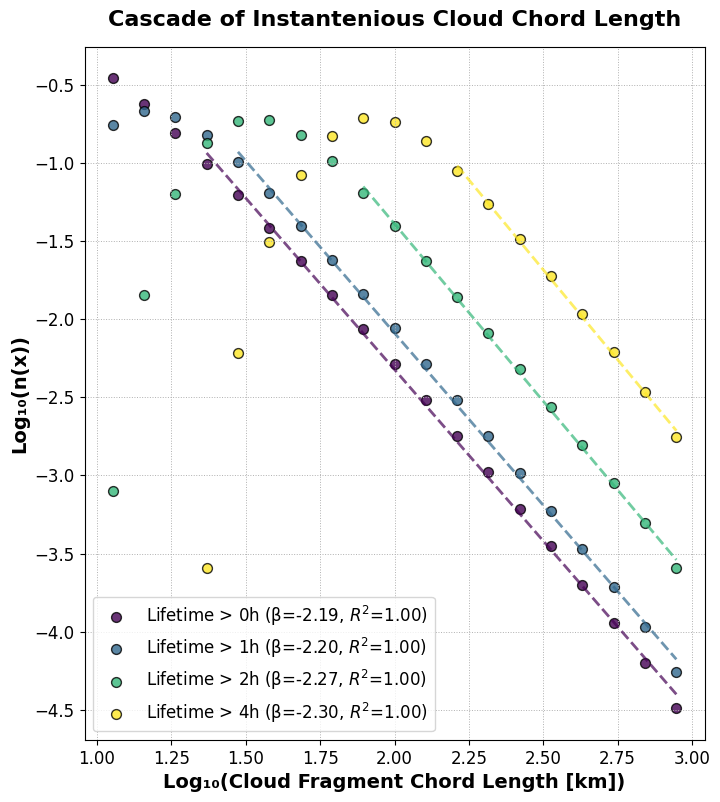

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

exponents = np.linspace(1, 3, 20)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width=bins[1:]-bins[:-1]
lifetime_thresholds = [0, 1, 2, 4]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud radius
    combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]*np.pi/8

    
    # Bin data
    #(combined_cloud_df["Cloud type"]=="Altostratus" ) & (combined_cloud_df["Cloud type"]!="" )&
    bin_counts = pd.cut(
        combined_cloud_df[ (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
        ]["norm_radius"], bins
    ).value_counts(sort=False)/bin_width
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()

    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[3:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=viridis_colors[i], s=50, alpha=0.8, edgecolors="black")
    
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=viridis_colors[i])

# Improve axes formatting
# ax.set_xscale("log")
# ax.set_ylim(-7,-2)
ax.set_title("Cascade of Instantenious Cloud Chord Length", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel(u"Log₁₀(Cloud Fragment Chord Length [km])", fontsize=14, fontweight='bold')
ax.set_ylabel(u"Log₁₀(n(x))", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")

# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
# plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Chord_length_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()


Chord length Straticumulus

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


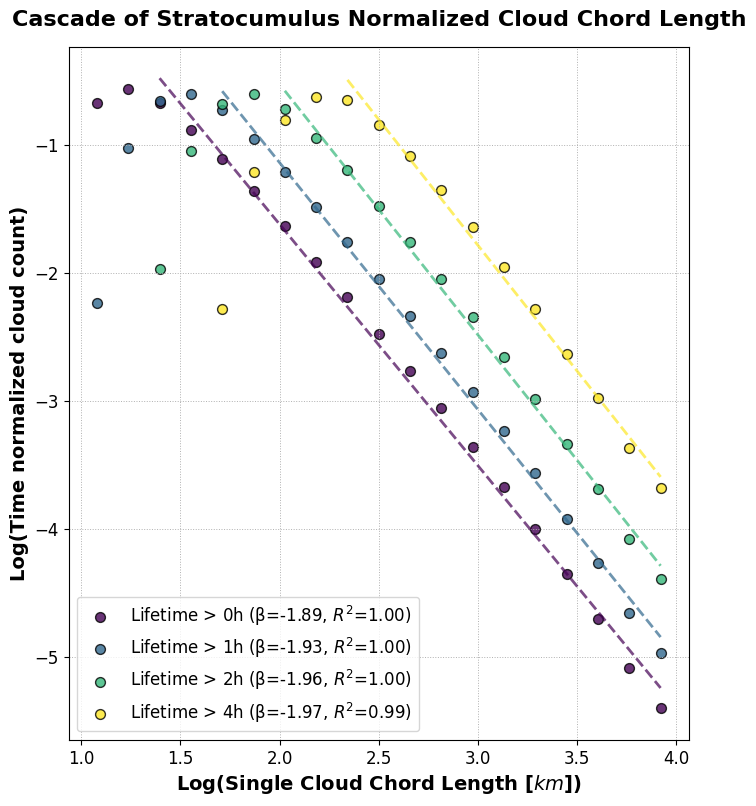

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

exponents = np.linspace(1, 4, 20)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width=bins[1:]-bins[:-1]
lifetime_thresholds = [0, 1, 2, 4]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud radius
    combined_cloud_df["norm_radius"] = combined_cloud_df["Radius [km]"] * combined_cloud_df["Lifetime [h]"]*np.pi/4

    # Bin data
    bin_counts = pd.cut(
        combined_cloud_df[(combined_cloud_df["Cloud type"]=="Stratocumulus") & (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)
        ]["norm_radius"], bins
    ).value_counts(sort=False)/bin_width
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()

    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[1:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=viridis_colors[i], s=50, alpha=0.8, edgecolors="black")
    
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=viridis_colors[i])

# Improve axes formatting
# ax.set_xscale("log")
# ax.set_ylim(-7,-2)
ax.set_title("Cascade of Stratocumulus Normalized Cloud Chord Length", fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel("Log(Single Cloud Chord Length [$km$])", fontsize=14, fontweight='bold')
ax.set_ylabel("Log(Time normalized cloud count)", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")

# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Statocumulus_chord_length_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()

Cloud area cascade

/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/cluster/work/climate/dnikolo/flex_trkr_2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


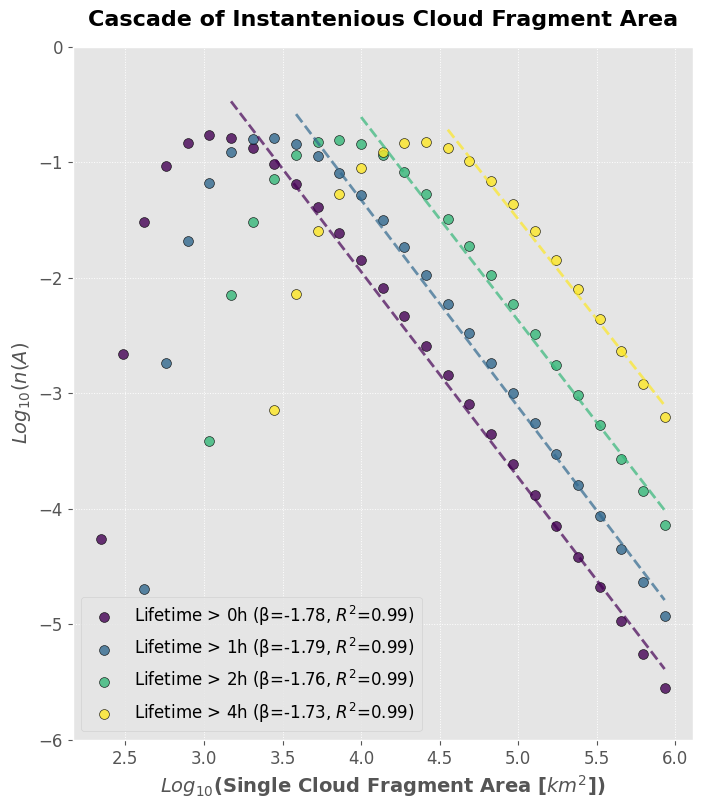

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score

# Use a modern style
plt.style.use("ggplot")

# Define the exponents and bins
exponents = np.linspace(2, 6, 30)
centers = exponents[:-1] + (exponents[1:] - exponents[:-1]) / 2
bins = np.power(10, exponents)
bin_width=bins[1:]-bins[:-1]
lifetime_thresholds = [0 ,1, 2, 4]

# Set up figure
fig, ax = plt.subplots(figsize=(8, 9))

# Use a colormap for better differentiation
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(lifetime_thresholds)))

for i, lifetime_thresh in enumerate(lifetime_thresholds):
    # Normalize cloud area
    combined_cloud_df["norm_area"] = combined_cloud_df["avg_size[km]"] * combined_cloud_df["Lifetime [h]"]

    # Bin data
    bin_counts = pd.cut(
        combined_cloud_df[ (combined_cloud_df["Lifetime [h]"] > lifetime_thresh)]["norm_area"], bins
    ).value_counts(sort=False)/bin_width#*3000*800/((3000-np.power(10,centers/2)/18-1)*(800-np.power(10,centers/2)/18-1))
    
    # Normalize bin counts
    new_df = pd.DataFrame({"bin_counts": bin_counts, "center": centers})
    new_df["bin_counts"] = new_df["bin_counts"] / new_df["bin_counts"].sum()
    
    # Fit line to the tail of the distribution
    fit_df = new_df[new_df["bin_counts"].idxmax():].iloc[1:]
    coef = np.polyfit(x=fit_df["center"], y=np.log10(fit_df["bin_counts"]), deg=1)
    poly1d_fn = np.poly1d(coef)
    
    # # Scatter plot with better markers
    # ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f})', 
    #            color=viridis_colors[i], s=50, alpha=0.8, edgecolors="black")
    R2 = r2_score(np.log10(fit_df["bin_counts"]), poly1d_fn(fit_df["center"]))
    # Scatter plot with better markers
    ax.scatter(new_df["center"], np.log10(new_df["bin_counts"]), label=f'Lifetime > {lifetime_thresh}h (β={coef[0]:.02f}, $R^2$={R2:.02f})', 
               color=viridis_colors[i], s=50, alpha=0.8, edgecolors="black")
    # Fitted line with better visibility
    ax.plot(fit_df["center"], poly1d_fn(fit_df["center"]), linestyle="--", linewidth=2, alpha=0.7, color=viridis_colors[i])

# Improve axes formatting
# ax.set_xscale("log")
ax.set_ylim(-6,0)
ax.set_xlabel("$Log_{10}$(Single Cloud Fragment Area [$km^2$])", fontsize=14, fontweight='bold')
ax.set_ylabel("$Log_{10}(n(A)$", fontsize=14, fontweight='bold')
ax.legend(fontsize=12, loc="lower left")
ax.set_title("Cascade of Instantenious Cloud Fragment Area", fontsize=16, fontweight='bold', pad=15)
# Add grid with minor ticks
ax.grid(True, which="both", linestyle=":", linewidth=0.7)
ax.tick_params(axis='both', which='major', labelsize=12)
plt.savefig(os.path.join(GTE_DIR,"Result_graphs/Avg_area_log_scale_cascade.png"),dpi=400)
# Show plot
plt.show()

Instantenious Cloud cover by fragment type

<Figure size 1000x600 with 0 Axes>

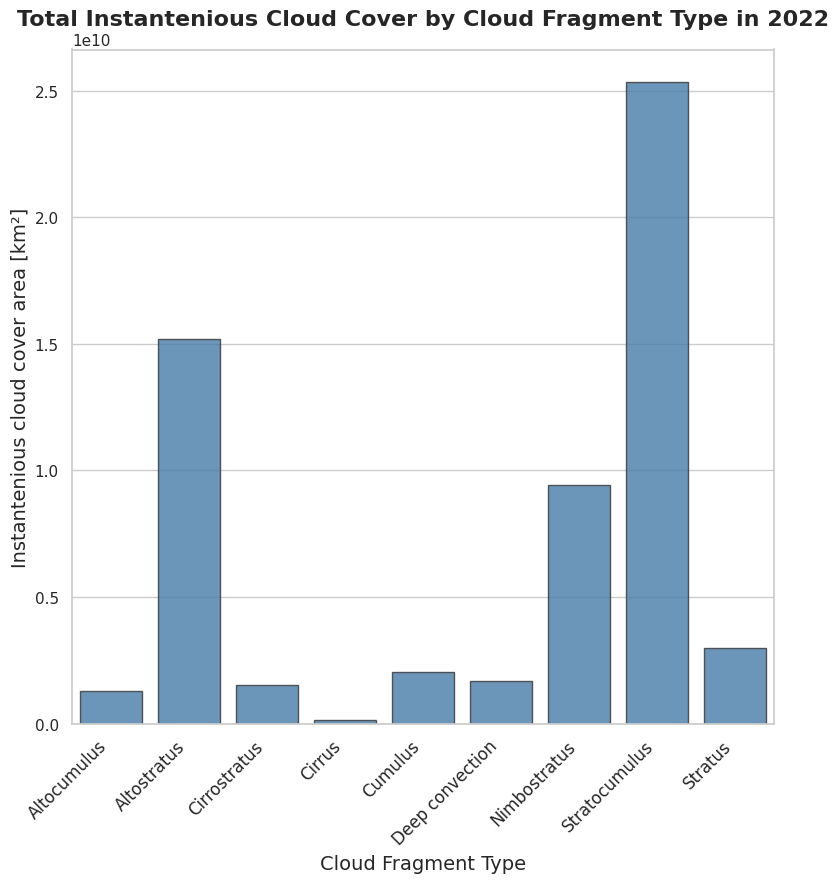

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall theme and style
sns.set_theme(style="whitegrid")

# Increase figure size for better clarity
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(8, 9))
# Create the histogram with a pastel palette and subtle edge viridis_colors
combined_cloud_df["norm_area"] = combined_cloud_df["avg_size[km]"] * combined_cloud_df["Lifetime [h]"]
total_area_per_clloud_type=combined_cloud_df.groupby("Cloud type")["norm_area"].sum()
total_area_per_clloud_type=total_area_per_clloud_type

ax = sns.barplot(
    x = total_area_per_clloud_type.index,
    y = total_area_per_clloud_type,
    color=classifiacation_palette[1],      # You can customize the color as desired
    edgecolor=".2",        # Adds a slight border for clarity
    alpha=0.8
)
# ax.bar_label(ax.containers[0], fontsize=10)
# Customize title and axis labels
ax.set_title("Total Instantenious Cloud Cover by Cloud Fragment Type in 2022", fontsize=16, fontweight='bold')
ax.set_xlabel("Cloud Fragment Type", fontsize=14)
ax.set_ylabel(u"Instantenious cloud cover area [km²]", fontsize=14)
# ax.set_ylim(0,0.7e5)
# Adjust x-ticks: rotate, adjust font size, and align to the left
plt.xticks(fontsize=12, rotation=45, ha='right')

# Improve layout spacing
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR, "Result_graphs/Type_area_distribution.png"),dpi=400)

Boxplot cloud of cloud area by cloud type

<Figure size 1000x600 with 0 Axes>

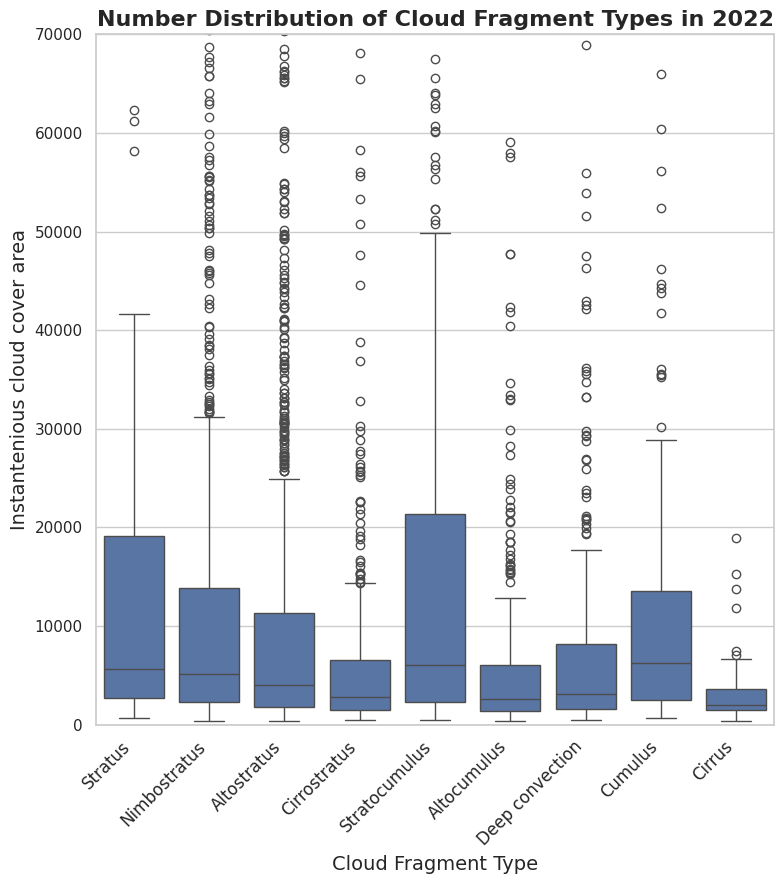

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the overall theme and style
sns.set_theme(style="whitegrid")

# Increase figure size for better clarity
plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(8, 9))
# Create the histogram with a pastel palette and subtle edge viridis_colors

# ax = sns.barplot(
#     x = combined_cloud_df.groupby("Cloud type")["norm_area"].sum().index,
#     y = combined_cloud_df.groupby("Cloud type")["norm_area"].sum(),
#     color=viridis_colors[0],      # You can customize the color as desired
#     edgecolor=".2"        # Adds a slight border for clarity
# )
combined_cloud_df["norm_area"] = combined_cloud_df["avg_size[km]"] * combined_cloud_df["Lifetime [h]"]
sns.boxplot(data=combined_cloud_df.sample(10000),ax=ax, x="Cloud type", y="norm_area")

# Customize title and axis labels
ax.set_title("Number Distribution of Cloud Fragment Types in 2022", fontsize=16, fontweight='bold')
ax.set_xlabel("Cloud Fragment Type", fontsize=14)
ax.set_ylabel("Instantenious cloud cover area", fontsize=14)
ax.set_ylim(0,0.7e5)
# Adjust x-ticks: rotate, adjust font size, and align to the left
plt.xticks(fontsize=12, rotation=45, ha='right')

# Improve layout spacing
plt.tight_layout()
# plt.savefig(os.path.join(GTE_DIR, "Type_area_distribution.png"),dpi=400)

Lifetime histogram by Pole

/cluster/work/climate/dnikolo/dump/ipykernel_2137306/2195898093.py:10: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.histplot(data=combined_cloud_df,


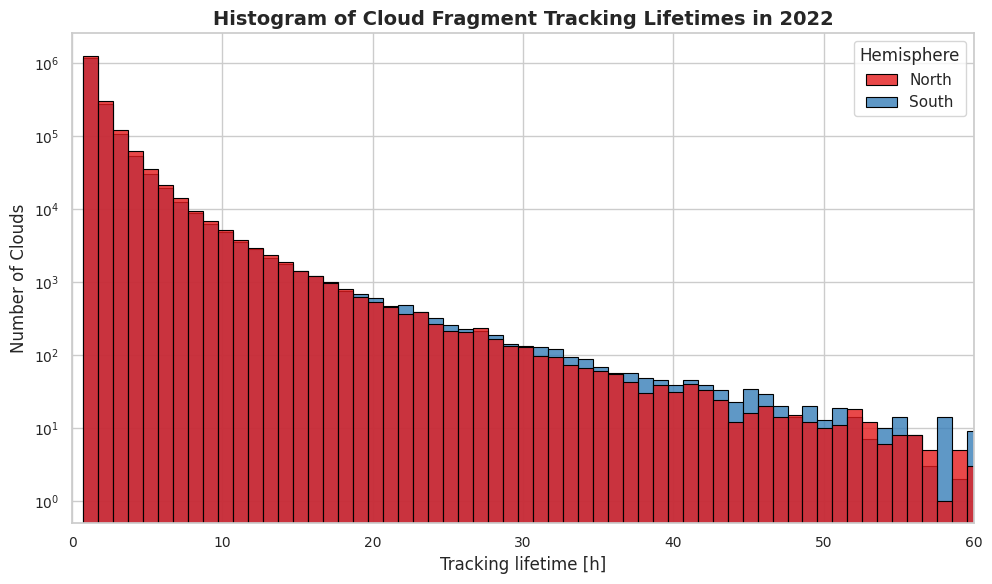

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Define the contrasting palette with the two specified viridis_colors


plt.figure(figsize=(10, 6))

sns.histplot(data=combined_cloud_df,
             x="Lifetime [h]",
             hue='Hemisphere',
             palette=classifiacation_palette,
             binwidth=1,
             log_scale=[False, True],
             edgecolor='black',
             linewidth=0.8,
             alpha=0.8)

plt.xlabel("Tracking lifetime [h]", fontsize=12)
plt.ylabel("Number of Clouds", fontsize=12)
plt.title("Histogram of Cloud Fragment Tracking Lifetimes in 2022", fontsize=14, fontweight='bold')

plt.yscale('log')
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.xlim(0,60)
filename = os.path.join(GTE_DIR, "Result_graphs/lifetime_hist_by_pole")
plt.savefig(filename + '.png', dpi=400)
plt.savefig(filename + '.pdf', dpi=400)

plt.show()



Ice containing clouds number histogram

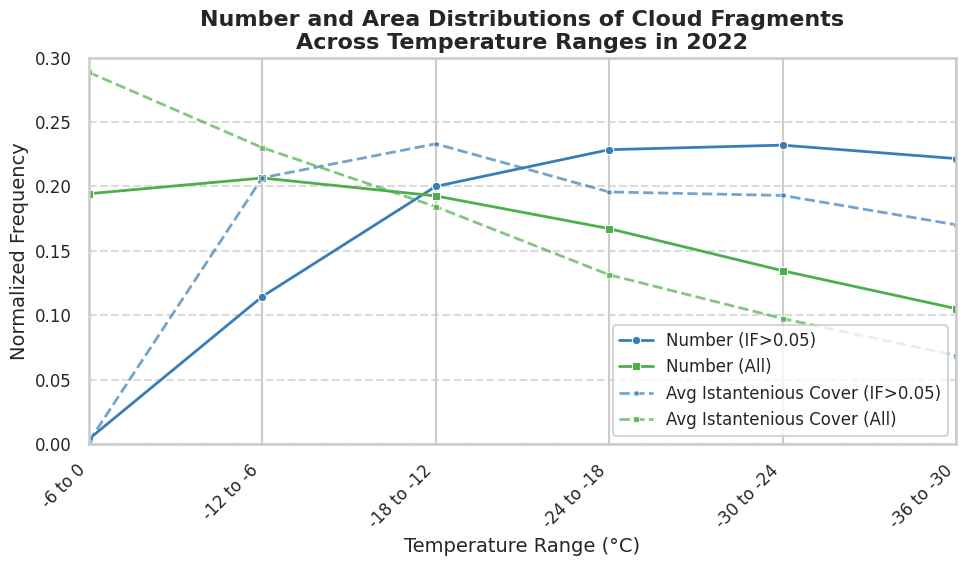

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create labels for the x-axis (temperature ranges)
labels = [f'{config["min_temp_arr"][i]} to {config["max_temp_arr"][i]}' 
          for i in range(len(config["min_temp_arr"]))]

# Prepare the data arrays
ice_mask = combined_cloud_df['max_ice_fraction'] > ice_cont_crit_frac
ice_data = combined_cloud_df[ice_mask]['min_temp'].value_counts(sort=False, normalize=True).to_numpy()
ice_area = combined_cloud_df[ice_mask].groupby('min_temp')["norm_area"].sum().iloc[::-1]
ice_area=ice_area/ice_area.sum()
all_data = combined_cloud_df['min_temp'].value_counts(sort=False, normalize=True).to_numpy()
all_area = combined_cloud_df.groupby('min_temp')["norm_area"].sum().iloc[::-1]
all_area=all_area/all_area.sum()
# Set a clean seaborn style and context for improved readability
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(10, 6))

# Plot with markers and thicker lines for clarity while preserving the colors

sns.lineplot(x=labels, y=ice_data, 
             color=classifiacation_palette[1], label="Number (IF>0.05)",
             marker='o', markersize=6, linewidth=2)
sns.lineplot(x=labels, y=all_data, 
             color=classifiacation_palette[2], label="Number (All)",
             marker='s', markersize=6, linewidth=2)
ax_1 = sns.lineplot(x=labels, y=ice_area, 
             color=classifiacation_palette[1], label="Avg Istantenious Cover (IF>0.05)",
             marker='o', markersize=4, linewidth=2, dashes=True, alpha=0.7)
ax_2 = sns.lineplot(x=labels, y=all_area, 
             color=classifiacation_palette[2], label="Avg Istantenious Cover (All)",
             marker='s', markersize=4, linewidth=2,dashes=True, alpha=0.7)
ax_1.lines[2].set_linestyle("--")
ax_2.lines[3].set_linestyle("--")

# Add title and axis labels with improved font sizing
plt.title('Number and Area Distributions of Cloud Fragments\nAcross Temperature Ranges in 2022', 
          fontsize=16, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12,rotation=45, ha='right')
plt.yticks(fontsize=12)

# Customize gridlines (y-axis only) for a cleaner look
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0,0.3)
plt.xlim(0,5)
# Optionally, if you prefer y-axis in percentages:
# from matplotlib.ticker import PercentFormatter
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# Customize the legend for clarity
plt.legend( fontsize=12, title_fontsize=13, 
           frameon=True, loc='lower right')

# Adjust layout and save the figure with high resolution
plt.tight_layout()
plt.savefig(os.path.join(GTE_DIR, 'Result_graphs/number_and_area_vs_temp_dist.png'), dpi=400)
plt.show()

In [39]:
combined_cloud_df.keys()

Index(['is_large_pix_cloud', 'is_cot_valid_cloud', 'is_ctp_valid_cloud',
       'is_liq', 'is_mix', 'is_ice', 'max_water_frac', 'max_ice_fraction',
       'avg_size[km]', 'max_size[km]', 'min_size[km]', 'avg_size[px]',
       'max_size[px]', 'min_size[px]', 'track_start_time', 'track_length',
       'avg_cot', 'avg_ctp', 'glaciation_start_time', 'glaciation_end_time',
       'avg_lat', 'avg_lon', 'start_ice_fraction', 'end_ice_fraction',
       'ice_frac_hist', 'cot_hist', 'cot_nan_frac_hist', 'ctp_hist',
       'ctp_nan_frac_hist', 'lat_hist', 'lon_hist', 'size_hist_km', 'min_temp',
       'max_temp', 'pole', 'Hemisphere', 'Lifetime [h]', 'Radius [km]',
       'Level', 'Optical Thickness', 'Cloud type', 'Season', 'norm_radius',
       'norm_area'],
      dtype='object')

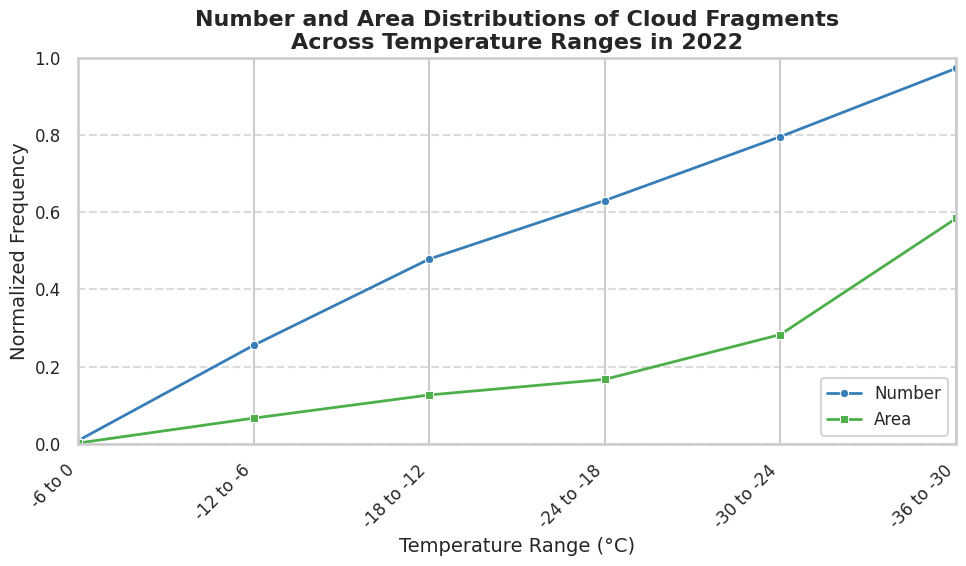

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Create labels for the x-axis (temperature ranges)
labels = [f'{config["min_temp_arr"][i]} to {config["max_temp_arr"][i]}' 
          for i in range(len(config["min_temp_arr"]))]
combined_cloud_df["ice_area"]=combined_cloud_df["norm_area"]*(combined_cloud_df["max_ice_fraction"])
# Prepare the data arrays
ice_mask = combined_cloud_df['max_ice_fraction'] > ice_cont_crit_frac
ice_data = combined_cloud_df[ice_mask]['min_temp'].value_counts(sort=False)
ice_area = combined_cloud_df.groupby('min_temp')["ice_area"].sum().iloc[::-1]
all_data = combined_cloud_df['min_temp'].value_counts(sort=False)
all_area = combined_cloud_df.groupby('min_temp')["norm_area"].sum().iloc[::-1]
# Set a clean seaborn style and context for improved readability
sns.set_style("whitegrid")
sns.set_context("talk")

plt.figure(figsize=(10, 6))

# Plot with markers and thicker lines for clarity while preserving the colors

sns.lineplot(x=labels, y=(ice_data/all_data), 
             color=classifiacation_palette[1], label="Number",
             marker='o', markersize=6, linewidth=2)
sns.lineplot(x=labels, y=ice_area/all_area, 
             color=classifiacation_palette[2], label="Area",
             marker='s', markersize=6, linewidth=2)
# ax_1 = sns.lineplot(x=labels, y=ice_area, 
#              color=classifiacation_palette[1], label="Avg Istantenious Cover (IF>0.05)",
#              marker='o', markersize=4, linewidth=2, dashes=True, alpha=0.7)
# ax_2 = sns.lineplot(x=labels, y=all_area, 
#              color=classifiacation_palette[2], label="Avg Istantenious Cover (All)",
#              marker='s', markersize=4, linewidth=2,dashes=True, alpha=0.7)
# ax_1.lines[2].set_linestyle("--")
# ax_2.lines[3].set_linestyle("--")

# Add title and axis labels with improved font sizing
plt.title('Number and Area Distributions of Cloud Fragments\nAcross Temperature Ranges in 2022', 
          fontsize=16, fontweight='bold')
plt.xlabel('Temperature Range (°C)', fontsize=14)
plt.ylabel('Normalized Frequency', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(fontsize=12,rotation=45, ha='right')
plt.yticks(fontsize=12)

# Customize gridlines (y-axis only) for a cleaner look
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0,1)
plt.xlim(0,5)
# Optionally, if you prefer y-axis in percentages:
# from matplotlib.ticker import PercentFormatter
# plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))

# Customize the legend for clarity
plt.legend( fontsize=12, title_fontsize=13, 
           frameon=True, loc='lower right')

# Adjust layout and save the figure with high resolution
plt.tight_layout()
# plt.savefig(os.path.join(GTE_DIR, 'Result_graphs/number_and_area_vs_temp_dist.png'), dpi=400)
plt.show()